In [2]:
pip install tensorflow

  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached tensorboard-2.9.0-py3-none-any.whl (5.8 MB)
  Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached tensorflow_estimator-2.9.0-py2.py3-none-any.whl (438 kB)
  Using cached libclang-14.0.1-py2.py3-none-win_amd64.whl (14.2 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
 

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import tensorflow as tf
from tensorflow import keras



ModuleNotFoundError: No module named 'tensorflow'

In [5]:
path = "C:/Users/tedjo/Downloads/XRAY/SplitData"

In [3]:
import te

SyntaxError: invalid syntax (2868172215.py, line 1)

In [6]:
'''Train'''
train_path = os.path.join(path, 'train')
'''Test'''
test_path = os.path.join(path, 'test')
'''Validation'''
val_path = os.path.join(path, 'val')

In [7]:
'''COVID_19'''

c_train_images = glob.glob(f'{train_path}/COVID/*.jpg')
'''Normal'''
n_train_images = glob.glob(f'{train_path}/NORMAL/*.jpg')
'''Pneumonia'''
p_train_images = glob.glob(f'{train_path}/PNEUMONIA/*.jpg')

In [8]:
dataFrame = pd.DataFrame(np.concatenate([[0]*len(c_train_images), [1]*len(n_train_images), [2]*len(p_train_images)]), columns=['Label'])

In [9]:
dataFrame

,Label
0,0
1,0
2,0
3,0
4,0
...,...
12237,2
12238,2
12239,2
12240,2


c:\Users\tedjo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


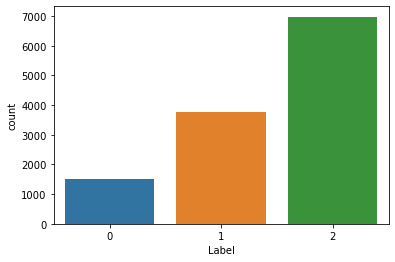

In [10]:
#plot the count 
ax = sns.countplot(dataFrame['Label'],data=dataFrame)
#label the number of data in each label
abs_counts = dataFrame['Label'].value_counts()
rel_values = dataFrame['Label'].value_counts(normalize=True).values
labels = [f'{p[0]} ({p[1]:.2f}%)' for p in zip(abs_counts.index, rel_values*100)]

([<matplotlib.patches.Wedge at 0x2a994e85490>,
 [Text(-0.23969862295914507, 1.0735662858675703, '2 (56.99%)'),
  Text(-0.18458480748809086, -1.084402346384673, '1 (30.65%)'),
  Text(1.0181209774729068, -0.4164488866951301, '0 (12.36%)')],
 [Text(-0.13074470343226094, 0.5855816104732201, '57.0%'),
  Text(-0.10068262226623137, -0.5914921889370943, '30.6%'),
  Text(0.5553387149852218, -0.22715393819734364, '12.4%')])

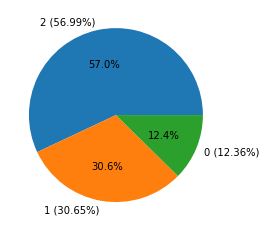

In [11]:
#print piechart 
plt.pie(rel_values, labels=labels, autopct='%1.1f%%')

In [12]:
#VGG16 model 
model16 = vgg16.VGG16(weights='imagenet', include_top=False,input_shape=(64,64,3))

#The layers in this layers are frozen meaning that the layer will not be trained
#This is will prevent the weight to be modified
for i in model16.layers:
    i.trainable = True

output = model16.output

output = keras.layers.GlobalAveragePooling2D()(output)

output = keras.layers.Dense(128, activation='relu')(output)

predictions = keras.layers.Dense(6, activation='softmax')(output)

model = keras.models.Model(inputs=model16.input, outputs=predictions)

lr = 0.1 
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=10000, decay_rate=0.96, staircase=True)

model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), metrics=['accuracy'])

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [14]:
train_dataset = ImageDataGenerator(rescale=1./255,shear_range=10, zoom_range = 0.2, horizontal_flip = True, 
                              width_shift_range=0.2, fill_mode = 'nearest' )

val_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
#flow from directory
train_dataset = train_dataset.flow_from_directory(train_path, target_size=(224, 224), batch_size=32, class_mode='sparse')

val_dataset = val_datagen.flow_from_directory(val_path, target_size=(224, 224), batch_size=16, class_mode= 'sparse')

test_dataset = val_datagen.flow_from_directory(test_path,target_size=(224, 224),batch_size = 64, class_mode= 'sparse')

Found 12242 images belonging to 3 classes.
Found 1530 images belonging to 3 classes.
Found 1532 images belonging to 3 classes.


In [16]:

#Fine tuning the model
lr = 1e-5 #Learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr,decay_steps =100000,decay_rate = 0.96, staircase = True)
#Implement early stopping 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
#Compile the model 
model.compile(optimizer= tf.keras.optimizers.RMSprop(lr_schedule),loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()])

In [17]:
#Training 
@jit
def run(epochs):
    history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[early_stopping])
    return history

run(epochs=10)

C:\Users\tedjo\AppData\Local\Temp/ipykernel_21816/325986300.py:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "run" failed type inference due to: Untyped global name 'model': Cannot determine Numba type of <class 'keras.engine.functional.Functional'>

File "..\..\..\AppData\Local\Temp\ipykernel_21816\325986300.py", line 4:
<source missing, REPL/exec in use?>

  @jit
c:\Users\tedjo\anaconda3\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "run" was compiled in object mode without forceobj=True.

File "..\..\..\AppData\Local\Temp\ipykernel_21816\325986300.py", line 2:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
c:\Users\tedjo\anaconda3\lib\site-packages\numba\core\object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more informatio

Epoch 1/10
  2/383 [..............................] - ETA: 1:00:10 - loss: 1.9087 - categorical_accuracy: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
#Save accuracy scores in an array 
accuracy_Scores = []
for i in history.history['accuracy']:
    accuracy_Scores.append(i)
accuracy_Scores.sort(reverse=True)

In [ ]:
accuracy_Scores

[0.8040624856948853,
 0.8006250262260437,
 0.7975518107414246,
 0.7969240546226501,
 0.7934374809265137,
 0.7922159433364868,
 0.7912499904632568,
 0.7909374833106995,
 0.7909374833106995,
 0.7884374856948853,
 0.7865625023841858,
 0.784375011920929,
 0.7834374904632568,
 0.7828124761581421,
 0.7824859023094177,
 0.7774999737739563,
 0.7684375047683716,
 0.762499988079071,
 0.7593749761581421,
 0.6359071135520935]

In [ ]:
#Model Evaluation 
final_Accuracy = model.evaluate_generator(test_dataset,1532)[1]

C:\Users\tedjo\AppData\Local\Temp/ipykernel_1340/2180378063.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  final_Accuracy = model.evaluate_generator(test_dataset,1532)[1]


In [ ]:
final_Accuracy

0.9471279382705688

TypeError: 'History' object is not subscriptable

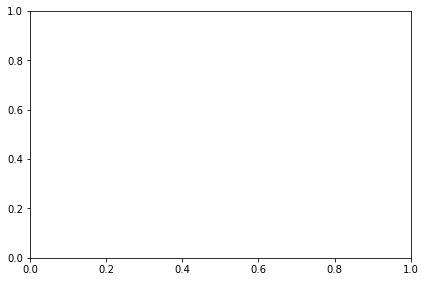

In [ ]:
#A graph to show the training and validation accuracy graph
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(model.history['accuracy'],label = 'Training Accuracy ')
plt.plot(history.history['val_accuracy'],label = 'Validation Accuracy')
plt.legend()
plt.title('Training V Validation Accuracy')

#Training and Validation Loss
plt.subplot(2,2,2)
plt.plot(history.history['accuracy'],label= 'Training Loss')
plt.plot(history.history['val_accuracy'],label= 'Validation Loss')
plt.legend()
plt.title("Training V Validation Loss")

plt.show()

In [ ]:
model.save('C:/Users/tedjo/Downloads/XRAY/COVID_Pneumonia_Normal_VGG16.h5')

In [7]:
#import metrics#
from sklearn.metrics import confusion_matrix, classification_report
print("Performance Summary of Convolutional Neural Network on test data")

#Show classification report 
print(classification_report(test_dataset.classes, model.predict_generator(test_dataset,1532).argmax(axis=1)))

#Show confusion matrix
print(confusion_matrix(test_dataset.classes, model.predict_generator(test_dataset,1532).argmax(axis=1)))

Performance Summary of Convolutional Neural Network on test data


NameError: name 'test_dataset' is not defined

In [2]:
model = keras.models.load_model('C:/Users/tedjo/Downloads/XRAY/COVID_Pneumonia_Normal_VGG16.h5')

ImportError: cannot import name 'dtensor' from 'tensorflow.compat.v2.experimental' (c:\Users\tedjo\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\_api\v2\compat\v2\experimental\__init__.py)

In [11]:
model.history()

In [12]:
import gradio as gr
def c_n_p(img):
    img = img.reshape((1,64,64,3,1))
    pred = model.predict(img).tolist()[0]
    class_names = ['COVID-19','Normal','Pneumonia']
    return{class_names[i]:pred[i] for i in range(len(class_names))}

im = gr.inputs.Image(shape=(6144,2),image_mode='L',invert_colors=False,source="upload")

ui = gr.Interface(fn=c_n_p,inputs=im,outputs=gr.outputs.Label())

ui.launch(share=True)

c:\Users\tedjo\anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
c:\Users\tedjo\anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7860/
Running on public URL: https://35542.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<gradio.routes.App at 0x187a1ea7ac0>,
 'http://127.0.0.1:7860/',
 'https://35542.gradio.app')

In [20]:
from numba import jit,cuda,numba

import numpy as np
from timeit import default_timer as timer
# To run on CPU
def func(a):
    for i in range(10000000):
        a[i]+= 1
# To run on GPU
@jit
def func2(x):
    return x+1
if __name__=="__main__":
    n = 10000000
    a = np.ones(n, dtype = np.float64)
    start = timer()
    func(a)
    print("without GPU:", timer()-start)
    start = timer()
    func2(a)
    numba.cuda.profile_stop()
    print("with GPU:", timer()-start)

without GPU: 5.641458300000522
with GPU: 0.21789220000209752


In [1]:
import tensorflow-gpu as tf

SyntaxError: invalid syntax (Temp/ipykernel_19932/2875605370.py, line 1)